<a href="https://colab.research.google.com/github/June103310110/AIACademy_Co-Note/blob/main/PART2/training_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 在資料集上測試 (MVtech)
資料集: 
> THE MVTEC ANOMALY DETECTION DATASET (MVTEC AD)
> https://www.mvtec.com/company/research/datasets/mvtec-ad


<img src="https://www.mvtec.com/fileadmin/Redaktion/mvtec.com/company/research/datasets/dataset_overview_large.png" alt="drawing" width="400"/>

In [ ]:
!pip install -q --user albumentations
!git clone https://github.com/June103310110/Image_Segmentation.git

fatal: destination path 'Image_Segmentation' already exists and is not an empty directory.


In [ ]:
import sys
import os
sys.path.append('/content/Image_Segmentation/PART2')
os.makedirs('saved', exist_ok=True)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import cv2
import numpy as np
import torch # 1.9
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import os
import torch.optim as optim
import time

# 從repo裡面導入套件
from utils import show_image_mask, mask_CutMix, patience
from unet import UNet


In [ ]:
#@title debug mode
#@markdown 出現cuda相關的error不一定真的是OOM或cuda error，請將torch的運行背景切換成cpu後再次確認錯誤訊息
device = "auto" #@param ['cuda', 'auto', 'cpu'] {type:"string"}

if device=='auto':
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE = 8 # 8 for 256x256/ 16 for 128x128
NUM_LABELS = 1
WIDTH = 256
HEIGHT = 256 
MULTI_CHANNELS = False

In [ ]:
unet = UNet(num_class=1, padding = 'same', out_sz=(WIDTH,HEIGHT), retain_dim=False)
unet#.to(device)
x    = torch.randn(1, 3, WIDTH, HEIGHT)#.to(device)
y_pred = unet(x)
y_pred.shape

del unet
# unet

In [ ]:
# import os   
cmd = '''mkdir ./data
wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz -O data/MVtech-capsule.tar.xz
tar -Jxf data/MVtech-capsule.tar.xz --overwrite --directory ./data
'''
if not os.path.isdir('./data/capsule'):
    for i in cmd.split('\n'):
        os.system(i)

In [ ]:
item = 'capsule'
path = os.getcwd()
img_dir = f'{path}/data/{item}/test/scratch/'
print(len(os.listdir(img_dir)))
anno_dir = f'{path}/data/{item}/ground_truth/scratch/'

defective_number = [i.split('.')[0] for i in os.listdir(img_dir)]

23


### 取得image list
輸出: data_dic (字典)
- key: X_train, X_test, y_train, y_test

In [ ]:
from sklearn.model_selection import train_test_split
mask_dir = lambda anno_dir, X_lis:[anno_dir+i.split('.')[0]+'_mask.png' for i in X_lis]

imgs_path_list = sorted(os.listdir(img_dir))

size = 1/len(imgs_path_list)
size = 0.1
train, test = train_test_split(imgs_path_list, train_size=size, random_state=43)

key = 'X_train, X_test, y_train, y_test'.split(', ')

lis = []
for number in [train, test]:
  lis.append([img_dir+i for i in number]) # X
for number in [train, test]:
  lis.append(mask_dir(anno_dir, number)) # y
data_dic = dict(zip(key, lis))
data_dic['X_train']

['/content/data/capsule/test/scratch/000.png',
 '/content/data/capsule/test/scratch/004.png']

### Build torch dataset

In [ ]:
#  https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class CustomImageDataset(Dataset):
  def __init__(self, imgs_path_list, anno_path_list, transform=None, multi_channel=False):
    self.imgs_path_list = imgs_path_list
    self.anno_path_list = anno_path_list
    if type(imgs_path_list) != list:
      raise ValueError('Need Input a list')
    if type(anno_path_list) != list:
      raise anno_path_list('Need Input a list')
    self.transform = transform
    self.multi_channel = multi_channel
#   
  def __len__(self):
    return len(self.imgs_path_list)
#         return 32

  def __getitem__(self, idx):
    img_path = self.imgs_path_list[idx]
    file_name = img_path.split('/')[-1].split('.')[0]
    mask_path = [i for i in self.anno_path_list if i.__contains__(file_name)][0]
    
    # cv2 read image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # (1000, 1000, 3)
#       
    # cv2 read mask
    mask = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE) # (1000, 1000) 
    
    if self.transform:
      transformed = self.transform(image=image, mask=mask)
      image = transformed['image']
      mask = transformed['mask']
    
    image = torch.Tensor(image)
    image = image.permute(2,0,1)
    
    mask = torch.Tensor(mask) 
    mask = mask.unsqueeze(0)
    mask = mask.float()/255.

    if self.multi_channel:
      '''
      cross entropy needed data type for multi-class predicted.
      '''
      
      mask = mask.squeeze(0)
      mask = mask.long()
        
    return image, mask
    

#### 補充: 如何從dataset抽image, mask出來

torch.Size([3, 1000, 1000])
torch.Size([1, 1000, 1000])
(1000, 1000, 3)
(1000, 1000)


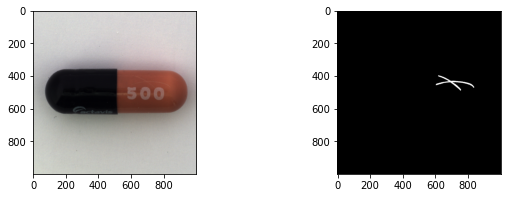

torch.Size([3, 1000, 1000])
torch.Size([1, 1000, 1000])
(1000, 1000, 3)
(1000, 1000)


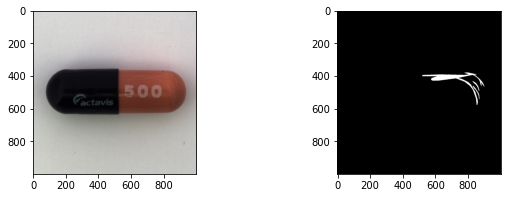

In [ ]:
a = CustomImageDataset(data_dic['X_train'], data_dic['y_train']
                       #, transform=transform
                      )
for idx in range(a.__len__()):
    test_image = a.__getitem__(idx)[0]
    test_mask = a.__getitem__(idx)[1]
    print(test_image.shape)
    print(test_mask.shape)
    
    test_image = test_image.permute(1,2,0).int().numpy()
    test_mask = test_mask.squeeze(0).int().numpy()
    print(test_image.shape)
    print(test_mask.shape)
    show_image_mask(test_image, test_mask)
    # break

### 使用albumentations進行資料擴增

In [ ]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/

transform = A.Compose([
  A.CenterCrop(300, 900, p=0.5),
  A.HorizontalFlip(p=0.5),
  A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
  A.Rotate((-30, 30), interpolation=0),  

  A.ToFloat(always_apply=True),
  A.Resize(WIDTH, HEIGHT),
])

target_transform = A.Compose([
  A.ToFloat(always_apply=True),
  A.Resize(WIDTH, HEIGHT),
])

In [ ]:
# 建議同時間只有16個(128,128)的sample進行計算 (Total = BATCH_SIZE*MULTIPLE_BATCH)

# 在這邊會強制對所有不滿BATCH_SIZE的訓練資料做數量上的匹配，接著透過CustomImageDataset的transform做資料擴增
if len(data_dic['X_train']) < 16: 
  lis = data_dic['X_train']
  lis = [lis[i%len(lis)] for i in range(BATCH_SIZE)]
  data_dic['X_train'] = lis


dataset_train = CustomImageDataset(data_dic['X_train'], data_dic['y_train'], transform=transform, multi_channel=MULTI_CHANNELS)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                                               pin_memory=True,)

dataset_test = CustomImageDataset(data_dic['X_train'], data_dic['y_train'], transform=target_transform, multi_channel=MULTI_CHANNELS) # **如果要正式使用要記得把這裡換成X_test
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=len(data_dic['X_test']), shuffle=False,
                                              pin_memory=True)


2
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


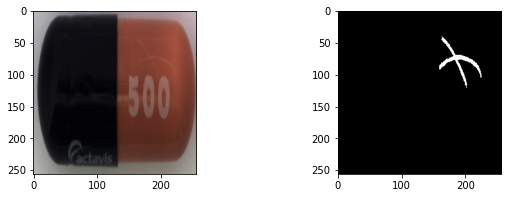

In [ ]:
'''test transform on dataloader_train'''
for data in dataloader_train:
  print(len(data))
  for x, y in zip(*data): # data裡面還包裹著image, mask，使用splat(*)可以把他小部拆解
      
    print(x.shape)
    print(y.shape)
    if MULTI_CHANNELS:
      show_image_mask(x.permute(1,2,0).numpy(), y.int())
    else:
      show_image_mask(x.permute(1,2,0).numpy(), y.squeeze(0).int())
    break

## 進行最佳化器與模型設計

In [ ]:
import torch
import torch.nn as nn
 
class DiceLoss(nn.Module):
	def __init__(self):
		super(DiceLoss, self).__init__()
 
	def	forward(self, input, target):
		N = target.size(0)
		smooth = 1
 
		input_flat = input.view(N, -1)
		target_flat = target.view(N, -1)
 
		intersection = input_flat * target_flat
 
		loss = 2 * (intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth)
		loss = 1 - loss.sum() / N
 
		return loss


In [ ]:
class BCEWithRCFLoss(nn.Module):
  '''
  red: https://github.com/meteorshowers/RCF-pytorch/blob/master/functions.py
  '''
  def __init__(self):
    super(BCEWithRCFLoss, self).__init__()
  
  def	forward(self, input, target):
    #target = target.long()
    mask = target.clone()
    mask = mask.float()
    num_positive = torch.sum((mask==1)).float()
    num_negative = torch.sum((mask==0)).float()

    mask[mask == 1] = 1.0 * num_negative / (num_positive + num_negative)
    mask[mask == 0] = 1.1 * num_positive / (num_positive + num_negative)
    cost = torch.nn.functional.binary_cross_entropy_with_logits(
            input.float(), target.float(), weight=mask, reduce=False)
    return torch.sum(cost)

### BCE_with_logit
二元分類，只有一個channel的輸出的場合。

In [ ]:
#@title 選擇超參數
#@markdown Relu, Linear在邊緣上的重現能力通常會比Sigmoid或Tanh更好

if not MULTI_CHANNELS:
  NUM_LABELS = 1

  activation = "Relu" #@param ['None', 'Relu', 'Sigmoid'] {type:"string"}

  dic = dict(zip(['None', 'Relu', 'Sigmoid'], [None, nn.ReLU(), nn.Sigmoid()]))
  activation = dic[activation]
  
  '''
  注意: 要在建立optimizer之前就把model的參數移到gpu裡面 
  ref: https://pytorch.org/docs/stable/optim.html 
  '''
  
  loss = "DiceLoss" #@param ['BCE', 'DiceLoss', 'BCEWithRCFLoss'] {type:"string"}
  dic = dict(zip(
      ['BCE', 'DiceLoss', 'BCEWithRCFLoss'],
      [nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([100])).to(device),
      DiceLoss().to(device),
      BCEWithRCFLoss().to(device)
      ]
  ))
  criterion = dic[loss]
  

  if criterion.__class__.__name__=='DiceLoss':
    activation = nn.Sigmoid()
    # 這邊幫各位強制做activation轉換了，不過請注意Diceloss需要使用Sigmoid
    assert activation.__class__.__name__=='Sigmoid', 'Diceloss need one channel output with Sigmoid function'

  """
  Net 超參數
  """
  #@markdown 設定Unet超參數，如果padding不等於same(Unet原始設計)，會自動在輸出層對特徵向量插值
  padding = 'same' #@param ['same', 'None'] {type:"string"}
  if padding=='same':
    retain_dim=False
  else:
    padding=0
    retain_dim=True

  model = UNet(num_class=NUM_LABELS, out_sz=(WIDTH,HEIGHT), activation=activation,
                                padding=padding,
                                retain_dim=retain_dim
              )
  model.to(device) 



  optimizer = optim.Adam(model.parameters(), lr = 1e-3)

  print(f'activation={activation}, \tcriterion = {criterion.__class__.__name__}, \tMULTI_CHANNELS = {MULTI_CHANNELS}')

activation=Sigmoid(), 	criterion = DiceLoss, 	MULTI_CHANNELS = False


### CE
交叉熵誤差，用於有多個channel的輸出的場合。

In [ ]:
'如果要使用CE(Cross entropy)，MULTI_CHANNELS需要在初始化data loader被設定為True'

if MULTI_CHANNELS:
  print(MULTI_CHANNELS)
  NUM_LABELS = 2 # 設定成你需要的輸出通道數
  assert NUM_LABELS>1, 'Multi channel?'
  activation = nn.Sigmoid()
  model = UNet(num_class=NUM_LABELS, out_sz=(WIDTH,HEIGHT), activation=activation)
  model.to(device) 
  '''
  Note: 
  要在建立optimizer之前就把model的參數移到gpu裡面  
  ref: https://pytorch.org/docs/stable/optim.html 
  '''

  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = optim.Adam(model.parameters(), lr = 1e-3)

  print(f'activation={activation}, \tcriterion = {criterion.__class__.__name__}, \tMULTI_CHANNELS = {MULTI_CHANNELS}')

In [ ]:
'final check'

print(f'activation {activation}, loss = {loss}, padding = \'{padding}\', MULTI_CHANNELS = {MULTI_CHANNELS}')

activation Sigmoid(), loss = DiceLoss, padding = 'same', MULTI_CHANNELS = False


## 訓練模型

In [ ]:
best_loss = None
monitor = patience(None)
times_to_show = 50

for epoch in range(501):  # loop over the dataset multiple times
  torch.cuda.empty_cache()
  running_loss = 0.0
  
  if monitor.early_stop:
    break
      
  monitor.time(times_to_show=50, show=True)
  for i, data in enumerate(dataloader_train, 1): # get each batch, setting drop_last
    inputs, mask = data
    inputs = inputs.to(device)
    mask = mask.to(device)
    # for i in range(len(inputs)):
    #   print(mask[i].min(), mask[i].max())
    '將梯度歸零'
    # zero the parameter gradients
    for param in model.parameters():
      param.grad = None
    
    '''
    也可以用下列程序來歸零梯度，但會消耗更多記憶體
    optimizer.zero_grad()
    '''

    '計算loss並進行反向傳播，更新模型的可訓練參數(那些requires_grad = True的Tensor)'
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, mask)
    loss.backward() # 將梯度綁定在各個可訓練的tensor上
    optimizer.step() # 用最佳化器將各個Tensor的梯度apply在Tensor上

    # print statistics
    running_loss += loss.item()

    running_loss = running_loss/len(inputs)
    if epoch%20==0 and i==1:
      print(f'epochs: {epoch}, average sample loss: {running_loss:.8f}')

    if not best_loss:
      best_loss = running_loss
    elif running_loss < 0.9*best_loss:
      best_loss = running_loss
      torch.save(model, 'saved/best_save.pt')
      monitor.reset()
      print('save torch model [best_save.pt]')

    monitor.record()
    running_loss = 0.0
torch.save(model, 'saved/last_save.pt')
        
# print('Finished Training')

0 epochs passed, ptime monitor every 50 epoch ['0.000']
epochs: 0, average sample loss: 0.12058765
No early stop
save torch model [best_save.pt]
epochs: 20, average sample loss: 0.10937764
epochs: 40, average sample loss: 0.11251017
50 epochs passed, ptime monitor every 50 epoch ['0.000', '54.182']
epochs: 60, average sample loss: 0.10043448
save torch model [best_save.pt]
epochs: 80, average sample loss: 0.09634839
100 epochs passed, ptime monitor every 50 epoch ['0.000', '54.182', '107.856']
epochs: 100, average sample loss: 0.08769587
save torch model [best_save.pt]
save torch model [best_save.pt]
epochs: 120, average sample loss: 0.06978196
save torch model [best_save.pt]
epochs: 140, average sample loss: 0.07605249
150 epochs passed, ptime monitor every 50 epoch ['0.000', '54.182', '107.856', '162.468']
epochs: 160, average sample loss: 0.06181021
save torch model [best_save.pt]
epochs: 180, average sample loss: 0.04911603
save torch model [best_save.pt]
200 epochs passed, ptime m

### 觀察訓練結果
由於時間有限，我們在這裡只觀察對「訓練資料集」進行訓練後的結果，預期狀態模型應該實現over-fit在訓練資料上。

In [ ]:
model = torch.load('./saved/last_save.pt')

8
tensor(0.1335, device='cuda:0', grad_fn=<RsubBackward1>)
torch.Size([8, 1, 256, 256])


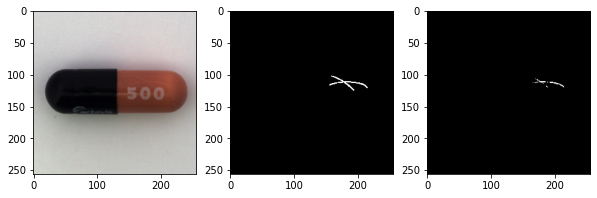

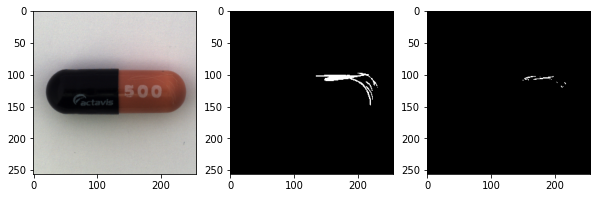

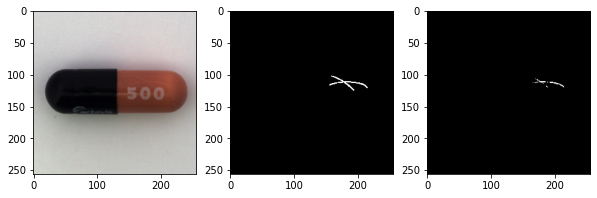

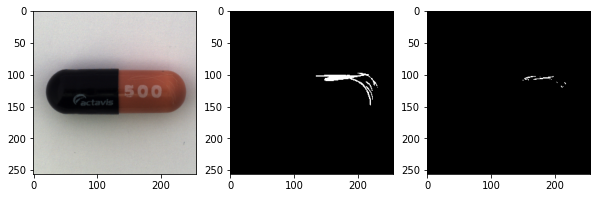

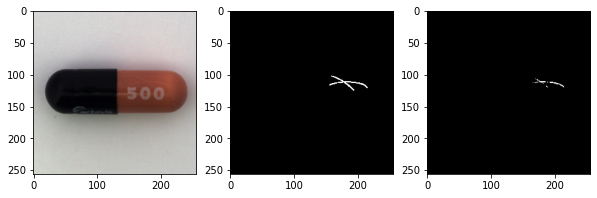

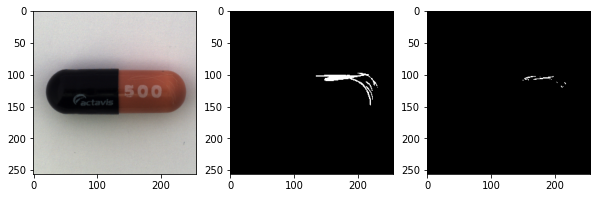

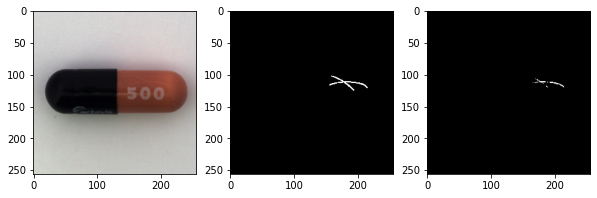

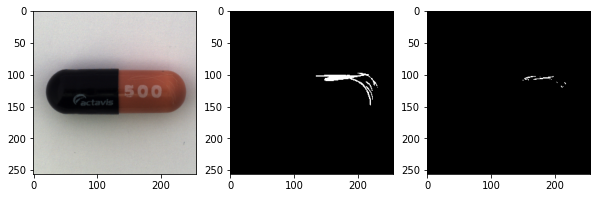

In [ ]:
def test_loop():
  for i, data in enumerate(dataloader_test, 1):
      torch.cuda.empty_cache()
      image, mask = data
      print(len(image))
      
      image = image.to(device)
      mask = mask.to(device)
      
      outputs = model(image)
      loss = criterion(outputs, mask)
      print(loss)

      if MULTI_CHANNELS:
        print(f'MULTI_CHANNELS = {MULTI_CHANNELS}, channels = {NUM_LABELS}')
        outputs = outputs[:,1,...] # 我們只有前景和後景，這裡指定前景

      '''
      設定閥值輸出:
      其實不設定也是可以輸出，不設定的情況會用灰階輸出，細節會更好一點
      '''
      if False: # 可以改成false，採灰階輸出， True的話會通過閾值輸出
        a = sum([i.max() for i in outputs])/len(outputs)
        b = sum([i.std() for i in outputs])/len(outputs)
        # 
        thres = a-1*b
        outputs[outputs>=thres] = 1 
        outputs[outputs<thres] = 0
        outputs = outputs.long()
      


      img_process = lambda image:image.cpu().permute(0,2,3,1)
      mask_process = lambda mask:mask.cpu().squeeze(1).permute(0,1,2)
      
      print(outputs.shape)
      for x, m, p in zip(img_process(image), mask_process(mask), mask_process(outputs)):
          show_image_mask(x, m, p)

test_loop()